In [ ]:
# The code has several repetitions which may not be ideal for production but a begginer may find it useful for easy undersatnding 
# I would recommend use of custom functions and methods and classes or even the sklearn pipeline for reusability and keeping your code clean

In [1]:
# import modules
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
import pickle

#classifiers
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# validators
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport
from sklearn.metrics import classification_report

#setting environment            
import warnings                                 
warnings.filterwarnings('ignore') 
import os                                       
import gc
from IPython.display import Image



In [2]:
# setting up environment and aesthetics

pd.options.display.max_columns =200
pd.options.display.max_rows =30
pd.options.display.float_format = '{:,.2f}'.format

#a fix for graphs sometimes not displaying on jupyter notebook due to the pylab deprecation
%pylab inline 

%matplotlib inline
plt.rcParams["figure.figsize"]=15,8
sns.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib


In [3]:

# Loading data
kilifi=pd.read_csv("data/Kilifi.csv")
Kwale=pd.read_csv("data/Kwale.csv")
Siaya=pd.read_csv("data/Siaya.csv")

In [4]:
# merging datas set
df=pd.concat([kilifi, Kwale, Siaya], ignore_index=True)
# dropping unseful columns
df=df.drop(["Child ID", "Mother ID", "Unnamed: 17"], axis=1)
df.tail()

,Child_Age,Sex,Mother_Age,Distance,Transport_Means,Time,Below_5_years,Marital_Status,Polygamy,Together,Education,Employment,Religion,Group_Membership,Place_of_Birth,Place _of_Sup,Income,Healthcare_Exp,Y
713,3.33,2.00,27.00,nan,1.00,1.00,2.00,1.00,2.00,1.00,4.00,1.00,1.00,1.00,3.00,3.00,49.63,4.96,1.00
714,3.42,1.00,30.00,1.00,1.00,1.00,2.00,1.00,2.00,1.00,3.00,4.00,1.00,1.00,3.00,3.00,29.78,1.99,1.00
715,4.50,2.00,35.00,1.00,1.00,1.00,2.00,1.00,2.00,1.00,5.00,2.00,1.00,nan,3.00,3.00,69.48,19.85,1.00
716,2.50,2.00,29.00,1.00,1.00,1.00,1.00,1.00,2.00,1.00,3.00,4.00,1.00,1.00,2.00,4.00,29.78,4.96,1.00
717,3.92,2.00,30.00,1.00,1.00,1.00,1.00,1.00,2.00,1.00,3.00,4.00,1.00,1.00,2.00,3.00,29.78,4.96,1.00


In [5]:
# creating test set early to avoid data snooping bias
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [6]:
# creating a copy of train set for visualization
vis_data=train_set.copy()


In [7]:
X_test=test_set.drop("Y", axis=1)
y_test=test_set["Y"]

### Correlation

In [8]:


# creating matrix of features to separate predictors and labels
X_train=vis_data.drop("Y", axis=1)
y_train=vis_data["Y"].copy()

# checking corelation
corr_matrix = vis_data.corr()
corr_matrix["Y"].sort_values(ascending=False)



Y                   1.00
Distance            0.22
Income              0.15
Group_Membership    0.10
Below_5_years       0.07
Together            0.07
Polygamy            0.05
Healthcare_Exp      0.05
Religion            0.03
Time                0.01
Mother_Age          0.00
Sex                -0.01
Place _of_Sup      -0.02
Marital_Status     -0.02
Transport_Means    -0.03
Place_of_Birth     -0.03
Employment         -0.06
Education          -0.12
Child_Age          -0.13
Name: Y, dtype: float64

## data preparation

In [9]:
X_train.head()

,Child_Age,Sex,Mother_Age,Distance,Transport_Means,Time,Below_5_years,Marital_Status,Polygamy,Together,Education,Employment,Religion,Group_Membership,Place_of_Birth,Place _of_Sup,Income,Healthcare_Exp
56,4.17,1.00,32.00,0.50,1.00,0.17,1.00,1.00,2.00,2.00,4.00,3.00,2.00,1.00,3.00,3.00,397.02,9.93
204,2.25,2.00,42.00,5.00,1.00,2.00,3.00,1.00,2.00,1.00,3.00,1.00,1.00,1.00,1.00,nan,148.88,3.47
319,2.25,2.00,27.00,2.00,1.00,0.75,2.00,1.00,2.00,1.00,3.00,1.00,3.00,1.00,1.00,2.00,49.63,6.95
529,4.33,1.00,22.00,0.25,1.00,0.42,3.00,1.00,2.00,1.00,2.00,3.00,2.00,1.00,3.00,3.00,9.93,4.96
24,3.08,2.00,30.00,1.00,1.00,0.17,1.00,1.00,2.00,1.00,4.00,2.00,3.00,1.00,3.00,3.00,nan,nan


In [10]:
# missing values
# filling numerical values with median value
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")
X_train_num = X_train[["Child_Age","Mother_Age","Time","Below_5_years","Distance","Income","Healthcare_Exp"]]
imputer.fit(X_train_num)
X = imputer.transform(X_train_num)
X

array([[4.1700e+00, 3.2000e+01, 1.7000e-01, ..., 5.0000e-01, 3.9702e+02,
        9.9300e+00],
       [2.2500e+00, 4.2000e+01, 2.0000e+00, ..., 5.0000e+00, 1.4888e+02,
        3.4700e+00],
       [2.2500e+00, 2.7000e+01, 7.5000e-01, ..., 2.0000e+00, 4.9630e+01,
        6.9500e+00],
       ...,
       [4.0000e+00, 3.0000e+01, 6.7000e-01, ..., 1.5000e+00, 1.7866e+02,
        9.9300e+00],
       [3.1700e+00, 4.5000e+01, 7.5000e-01, ..., 2.0000e+00, 1.4890e+01,
        2.9800e+00],
       [2.2500e+00, 4.2000e+01, 1.0000e+00, ..., 1.0000e+00, 2.9780e+01,
        2.9800e+00]])

In [11]:
# Feature scaling

# Our data is not normally distributed and has some noticeable outliers especially in the caregivers income so we will use Robust 
# Scaler to standerdize the data. We will also use SVM which relies on uclidean distance between two data points for computation

from sklearn.preprocessing import RobustScaler
rob_scaler=RobustScaler()
X_train_scaled=rob_scaler.fit_transform(X)
X_train_scaled

array([[ 0.568     ,  0.44444444, -0.78571429, ..., -0.75      ,
         7.40104796,  1.09357798],
       [-0.2       ,  1.55555556,  3.57142857, ...,  1.5       ,
         2.40024184, -0.09174312],
       [-0.2       , -0.11111111,  0.5952381 , ...,  0.        ,
         0.40004031,  0.54678899],
       ...,
       [ 0.5       ,  0.22222222,  0.4047619 , ..., -0.25      ,
         3.00040306,  1.09357798],
       [ 0.168     ,  1.88888889,  0.5952381 , ...,  0.        ,
        -0.30008061, -0.18165138],
       [-0.2       ,  1.55555556,  1.19047619, ..., -0.5       ,
         0.        , -0.18165138]])

In [12]:
# converting to dataframe
X_train_num_prep=pd.DataFrame(X_train_scaled, columns=X_train_num.columns)
X_train_num_prep.tail()

,Child_Age,Mother_Age,Time,Below_5_years,Distance,Income,Healthcare_Exp
569,-0.20,0.11,0.00,0.00,-0.75,0.00,0.00
570,-0.30,0.44,1.19,1.00,0.00,0.00,0.00
571,0.50,0.22,0.40,-1.00,-0.25,3.00,1.09
572,0.17,1.89,0.60,0.00,0.00,-0.30,-0.18
573,-0.20,1.56,1.19,-1.00,-0.50,0.00,-0.18


In [13]:
# filling categorical values with mode
from sklearn.preprocessing import Imputer
imputer_cat = Imputer(strategy="most_frequent")
X_train_cat= X_train.drop(X_train_num, axis=1)
imputer_cat.fit(X_train_cat)
filled_cat = imputer_cat.transform(X_train_cat)
filled_cat

array([[1., 1., 1., ..., 1., 3., 3.],
       [2., 1., 1., ..., 1., 1., 2.],
       [2., 1., 1., ..., 1., 1., 2.],
       ...,
       [1., 1., 1., ..., 1., 2., 3.],
       [1., 1., 1., ..., 1., 3., 1.],
       [1., 1., 1., ..., 2., 3., 2.]])

In [14]:
# converting to dataframe
X_train_cat_df=pd.DataFrame(filled_cat, columns=X_train_cat.columns)
X_train_cat_df.tail()

,Sex,Transport_Means,Marital_Status,Polygamy,Together,Education,Employment,Religion,Group_Membership,Place_of_Birth,Place _of_Sup
569,1.00,1.00,1.00,1.00,2.00,1.00,3.00,1.00,2.00,3.00,2.00
570,1.00,1.00,1.00,2.00,2.00,2.00,3.00,1.00,1.00,3.00,2.00
571,1.00,1.00,1.00,1.00,1.00,4.00,2.00,1.00,1.00,2.00,3.00
572,1.00,1.00,1.00,1.00,1.00,3.00,1.00,3.00,1.00,3.00,1.00
573,1.00,1.00,1.00,2.00,1.00,2.00,1.00,4.00,2.00,3.00,2.00


In [15]:
# encoding categorical values with pandas get dummies
X_train_cat_prep=pd.get_dummies(data=X_train_cat_df, columns=['Transport_Means', 'Education', 'Employment', 'Religion','Place_of_Birth','Place _of_Sup'])
X_train_cat_prep.shape


(574, 30)

In [16]:
# merging prepared categorical and numerical data
X_train_prep=pd.concat([X_train_num_prep,X_train_cat_prep], axis=1)
X_train_prep=X_train_prep.drop("Place_of_Birth_4.0", axis=1)
X_train_prep.head()

,Child_Age,Mother_Age,Time,Below_5_years,Distance,Income,Healthcare_Exp,Sex,Marital_Status,Polygamy,Together,Group_Membership,Transport_Means_1.0,Transport_Means_2.0,Transport_Means_3.0,Transport_Means_4.0,Education_1.0,Education_2.0,Education_3.0,Education_4.0,Education_5.0,Employment_1.0,Employment_2.0,Employment_3.0,Employment_4.0,Religion_1.0,Religion_2.0,Religion_3.0,Religion_4.0,Place_of_Birth_1.0,Place_of_Birth_2.0,Place_of_Birth_3.0,Place _of_Sup_1.0,Place _of_Sup_2.0,Place _of_Sup_3.0,Place _of_Sup_4.0
0,0.57,0.44,-0.79,-1.00,-0.75,7.40,1.09,1.00,1.00,2.00,2.00,1.00,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0
1,-0.20,1.56,3.57,1.00,1.50,2.40,-0.09,2.00,1.00,2.00,1.00,1.00,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0
2,-0.20,-0.11,0.60,0.00,0.00,0.40,0.55,2.00,1.00,2.00,1.00,1.00,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0
3,0.63,-0.67,-0.19,1.00,-0.88,-0.40,0.18,1.00,1.00,2.00,1.00,1.00,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0
4,0.13,0.22,-0.79,-1.00,-0.50,0.00,0.00,2.00,1.00,2.00,1.00,1.00,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0


In [17]:
# filling missing values in y train set
imputer = Imputer(strategy="most_frequent")
imputer.fit(y_train.values.reshape(-1,1))
y_train_prep = imputer.transform(y_train.values.reshape(-1,1))

### preparing test set

In [18]:
#preparing numerical data

# missing values
# filling numerical values with median value
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")
X_test_num = X_test[["Child_Age","Mother_Age","Time","Below_5_years","Distance","Income","Healthcare_Exp"]]
imputer.fit(X_test_num)
X = imputer.transform(X_test_num)
X

# Feature scaling
from sklearn.preprocessing import RobustScaler
rob_scaler=RobustScaler()
X_test_scaled=rob_scaler.fit_transform(X)
X_test_scaled

# converting to dataframe
X_test_num_prep=pd.DataFrame(X_test_scaled, columns=X_test_num.columns)
X_test_num_prep.tail()

,Child_Age,Mother_Age,Time,Below_5_years,Distance,Income,Healthcare_Exp
139,0.16,-0.73,1.19,-1.00,7.30,0.00,-0.25
140,-0.32,-1.09,0.40,-1.00,-0.10,1.99,6.75
141,0.16,-0.12,-1.00,-1.00,-0.50,1.13,5.50
142,-0.11,0.61,0.00,0.00,-0.50,0.43,-0.50
143,-0.95,-0.48,0.60,-1.00,1.70,-0.28,0.50


In [ ]:
# preparing categorical data

# filling categorical values with mode
from sklearn.preprocessing import Imputer
imputer_cat = Imputer(strategy="most_frequent")
X_test_cat= X_test.drop(X_test_num, axis=1)
imputer_cat.fit(X_test_cat)
filled_cat = imputer_cat.transform(X_test_cat)
filled_cat
# converting to dataframe
X_test_cat_df=pd.DataFrame(filled_cat, columns=X_test_cat.columns)
X_test_cat_df.tail()

# encoding categorical values with pandas get dummies
X_test_cat=pd.get_dummies(data=X_test_cat_df, columns=['Transport_Means', 'Education', 'Employment', 'Religion','Place_of_Birth','Place _of_Sup'])
X_test_cat.head()

,Sex,Marital_Status,Polygamy,Together,Group_Membership,Transport_Means_1.0,Transport_Means_2.0,Transport_Means_3.0,Transport_Means_4.0,Education_1.0,Education_2.0,Education_3.0,Education_4.0,Education_5.0,Education_6.0,Employment_1.0,Employment_2.0,Employment_3.0,Employment_4.0,Religion_1.0,Religion_2.0,Religion_3.0,Religion_4.0,Place_of_Birth_1.0,Place_of_Birth_2.0,Place_of_Birth_3.0,Place _of_Sup_1.0,Place _of_Sup_2.0,Place _of_Sup_3.0,Place _of_Sup_4.0
0,2.00,1.00,2.00,2.00,2.00,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0
1,1.00,1.00,2.00,1.00,2.00,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0
2,1.00,1.00,2.00,1.00,2.00,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0
3,1.00,1.00,2.00,1.00,1.00,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0
4,2.00,1.00,2.00,1.00,1.00,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0


In [ ]:
#merging data
X_test_prep=pd.concat([X_test_num_prep,X_test_cat], axis=1)
X_test_prep=X_test_prep.drop("Education_6.0", axis=1)
X_test_prep.head()

,Child_Age,Mother_Age,Time,Below_5_years,Distance,Income,Healthcare_Exp,Sex,Marital_Status,Polygamy,Together,Group_Membership,Transport_Means_1.0,Transport_Means_2.0,Transport_Means_3.0,Transport_Means_4.0,Education_1.0,Education_2.0,Education_3.0,Education_4.0,Education_5.0,Employment_1.0,Employment_2.0,Employment_3.0,Employment_4.0,Religion_1.0,Religion_2.0,Religion_3.0,Religion_4.0,Place_of_Birth_1.0,Place_of_Birth_2.0,Place_of_Birth_3.0,Place _of_Sup_1.0,Place _of_Sup_2.0,Place _of_Sup_3.0,Place _of_Sup_4.0
0,0.84,0.00,-0.79,0.00,2.50,1.13,6.75,2.00,1.00,2.00,2.00,2.00,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0
1,0.00,-1.21,-0.79,-1.00,-0.50,-0.57,-0.75,1.00,1.00,2.00,1.00,2.00,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0
2,0.84,0.00,-0.60,0.00,-0.30,0.00,0.00,1.00,1.00,2.00,1.00,2.00,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0
3,-0.74,0.24,-0.19,-1.00,0.10,-0.28,1.00,1.00,1.00,2.00,1.00,1.00,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0
4,0.84,1.58,-0.40,0.00,-0.30,0.28,0.00,2.00,1.00,2.00,1.00,1.00,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0


In [ ]:
# filling missing values in y test set
imputer = Imputer(strategy="most_frequent")
imputer.fit(y_test.values.reshape(-1,1))
y_test_prep = imputer.transform(y_test.values.reshape(-1,1))

### Model evaluation

In [ ]:
#checking performance of random forest on oversampled dataset
#training random forest
forest_clf = RandomForestClassifier()
forest_clf.fit(X_train_prep, y_train_prep)

# checking performance for oversampled on random forest
forest_pred=forest_clf.predict(X_test_prep)

# checking class balance in prediction
print( np.unique( forest_pred ) )

 
# checking accuracy
print("Accuracy: ", accuracy_score(y_test_prep, forest_pred))

 
# AUCROC score
forest_roc = forest_clf.predict_proba(X_test_prep)
forest_roc = forest_roc[:,1]
print( "ROC: ",roc_auc_score(y_test_prep, forest_roc ))

# classification report
print (classification_report(y_test_prep, forest_pred))

[1. 2.]
Accuracy:  0.8819444444444444
ROC:  0.8340277777777777
              precision    recall  f1-score   support

         1.0       0.89      0.97      0.93       120
         2.0       0.77      0.42      0.54        24

   micro avg       0.88      0.88      0.88       144
   macro avg       0.83      0.70      0.74       144
weighted avg       0.87      0.88      0.87       144



In [ ]:
# checking performance of xgboost on oversampled data
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train_prep, y_train_prep)

# Predict on training set
xgb_pred = xgb_clf.predict(X_test_prep)
 
# checking class balance in prediction
print(np.unique(xgb_pred ) )

 
# checking accuracy
print( "Accuracy: ",accuracy_score(y_test_prep, xgb_pred) )

 
# AUCROC score
svm_roc = xgb_clf.predict_proba(X_test_prep)
svm_roc = svm_roc[:,1]
print("AUCROC score: ", roc_auc_score(y_test_prep, svm_roc) )

# classification report
print (classification_report(y_test_prep, xgb_pred))

[1. 2.]
Accuracy:  0.8541666666666666
AUCROC score:  0.8663194444444444
              precision    recall  f1-score   support

         1.0       0.90      0.93      0.91       120
         2.0       0.58      0.46      0.51        24

   micro avg       0.85      0.85      0.85       144
   macro avg       0.74      0.70      0.71       144
weighted avg       0.84      0.85      0.85       144



In [ ]:
# checking performance of svm on oversampled data
svm_clf = SVC(kernel='linear', 
            class_weight='balanced', # penalize
            probability=True)
 
svm_clf.fit(X_train_prep, y_train_prep)

# Predict on training set
svm_pred = svm_clf.predict(X_test_prep)
 
# checking class balance in prediction
print( np.unique( svm_pred ) )

 
# checking accuracy
print("Accuracy: ", accuracy_score(y_test_prep, svm_pred) )

 
# AUCROC score
svm_roc = svm_clf.predict_proba(X_test_prep)
svm_roc = svm_roc[:,1]
print("AUCROC score: ", roc_auc_score(y_test_prep, svm_roc) )

# classification report
print (classification_report(y_test_prep, svm_pred))

[1. 2.]
Accuracy:  0.7638888888888888
AUCROC score:  0.8288194444444444
              precision    recall  f1-score   support

         1.0       0.96      0.75      0.84       120
         2.0       0.40      0.83      0.54        24

   micro avg       0.76      0.76      0.76       144
   macro avg       0.68      0.79      0.69       144
weighted avg       0.86      0.76      0.79       144



In [ ]:
# checking performance of Naive Bayes on oversampled data
naive_clf = GaussianNB()
naive_clf.fit(X_train_prep, y_train_prep)


# Predict on training set
naive_pred = naive_clf.predict(X_test_prep)
 
# checking class balance in prediction
print( np.unique( naive_pred ) )

 
# checking accuracy
print( "Accuracy:",accuracy_score(y_test_prep, naive_pred) )

 
# AUCROC score
svm_roc = naive_clf.predict_proba(X_test_prep)
svm_roc = svm_roc[:,1]
print( "ROC:", roc_auc_score(y_test_prep, svm_roc) )

# classification report
print (classification_report(y_test_prep, naive_pred))

[1. 2.]
Accuracy: 0.5069444444444444
ROC: 0.7243055555555555
              precision    recall  f1-score   support

         1.0       0.96      0.42      0.59       120
         2.0       0.24      0.92      0.38        24

   micro avg       0.51      0.51      0.51       144
   macro avg       0.60      0.67      0.49       144
weighted avg       0.84      0.51      0.56       144



### Resampling

In [ ]:
majority=df[df.Y==1]
minority=df[df.Y==2]

In [ ]:
df["Y"].value_counts()

1.00    611
2.00    101
Name: Y, dtype: int64

In [ ]:
from sklearn.utils import resample
# balancing classes by oversampling

# Upsample majority class
minority_oversampled = resample(minority, 
                                 replace=True,    # sample without replacement
                                 n_samples=611,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_over = pd.concat([minority_oversampled, majority])
 
# Display new class counts
df_over.Y.value_counts()

1.00    611
2.00    611
Name: Y, dtype: int64

In [ ]:
# balancing classes by undersampling

majority=df[df.Y==1]
minority=df[df.Y==2]

# Downsample majority class
majority_undersampled = resample(majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=101,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_under = pd.concat([majority_undersampled, minority])
 
# Display new class counts
df_under.Y.value_counts()

2.00    101
1.00    101
Name: Y, dtype: int64

In [ ]:
# splitting train and test set
train_set_o, test_set_o = train_test_split(df_over, test_size=0.2, random_state=42)
# defining X and Y axis
X_train_over=train_set_o.drop("Y", axis=1)
y_train_over=train_set_o["Y"]
X_test_over=test_set_o.drop("Y", axis=1)
y_test_over=test_set_o["Y"]
X_train_over.head()

,Child_Age,Sex,Mother_Age,Distance,Transport_Means,Time,Below_5_years,Marital_Status,Polygamy,Together,Education,Employment,Religion,Group_Membership,Place_of_Birth,Place _of_Sup,Income,Healthcare_Exp
212,3.50,2.00,38.00,4.00,1.00,0.63,2.00,1.00,2.00,1.00,3.00,1.00,2.00,1.00,1.00,nan,97.27,1.99
155,1.42,1.00,30.00,20.00,1.00,0.75,1.00,1.00,2.00,1.00,2.00,3.00,1.00,1.00,1.00,nan,24.81,1.99
475,8.00,1.00,32.00,1.00,3.00,0.33,nan,1.00,2.00,1.00,3.00,3.00,1.00,1.00,3.00,nan,29.78,4.96
419,0.75,1.00,31.00,1.50,1.00,1.00,3.00,2.00,nan,nan,4.00,3.00,3.00,1.00,3.00,1.00,19.85,0.99
206,3.00,2.00,27.00,1.80,3.00,0.17,2.00,1.00,2.00,2.00,1.00,1.00,1.00,2.00,1.00,nan,59.55,0.20


## preparing overersampled datapoints

### Train set preparation

In [ ]:
#preparing numerical data

# missing values
# filling numerical values with median value
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")
X_train_num_over = X_train_over[["Child_Age","Mother_Age","Time","Below_5_years","Distance","Income","Healthcare_Exp"]]
imputer.fit(X_train_num_over)
X = imputer.transform(X_train_num_over)
X

# Feature scaling
from sklearn.preprocessing import RobustScaler
rob_scaler=RobustScaler()
X_train_scaled=rob_scaler.fit_transform(X)
X_train_scaled

# converting to dataframe
X_train_num_over_prep=pd.DataFrame(X_train_scaled, columns=X_train_num.columns)
X_train_num_over_prep.tail()

,Child_Age,Mother_Age,Time,Below_5_years,Distance,Income,Healthcare_Exp
972,-0.80,-0.50,-0.19,-1.00,-0.50,-0.60,-0.80
973,0.75,0.38,-0.40,-1.00,-0.65,0.00,0.00
974,0.12,-0.12,0.00,0.00,0.50,-0.50,0.40
975,-0.20,0.00,1.19,0.00,0.50,-0.60,-0.80
976,0.24,0.25,0.40,-1.00,0.50,-0.48,1.20


In [ ]:
# preparing categorical data

# filling categorical values with mode
from sklearn.preprocessing import Imputer
imputer_cat = Imputer(strategy="most_frequent")
X_train_cat= X_train_over.drop(X_train_num_over, axis=1)
imputer_cat.fit(X_train_cat)
filled_cat = imputer_cat.transform(X_train_cat)
filled_cat
# converting to dataframe
X_train_cat_df=pd.DataFrame(filled_cat, columns=X_train_cat.columns)
X_train_cat_df.tail()

# encoding categorical values with pandas get dummies
X_train_cat_over=pd.get_dummies(data=X_train_cat_df, columns=['Transport_Means', 'Education', 'Employment', 'Religion','Place_of_Birth','Place _of_Sup'])
#balancing the number of features in categorical and numerical datasets
X_train_cat_over=X_train_cat_over.drop(["Education_6.0"], axis=1)

X_train_cat_over.head()

,Sex,Marital_Status,Polygamy,Together,Group_Membership,Transport_Means_1.0,Transport_Means_2.0,Transport_Means_3.0,Transport_Means_4.0,Education_1.0,Education_2.0,Education_3.0,Education_4.0,Education_5.0,Employment_1.0,Employment_2.0,Employment_3.0,Employment_4.0,Religion_1.0,Religion_2.0,Religion_3.0,Religion_4.0,Place_of_Birth_1.0,Place_of_Birth_2.0,Place_of_Birth_3.0,Place_of_Birth_4.0,Place _of_Sup_1.0,Place _of_Sup_2.0,Place _of_Sup_3.0,Place _of_Sup_4.0
0,2.00,1.00,2.00,1.00,1.00,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
1,1.00,1.00,2.00,1.00,1.00,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0
2,1.00,1.00,2.00,1.00,1.00,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
3,1.00,2.00,2.00,1.00,1.00,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0
4,2.00,1.00,2.00,2.00,2.00,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0


In [ ]:
#merging numerical and categorical data
X_train_over_prep=pd.concat([X_train_num_over_prep,X_train_cat_over], axis=1)
X_train_over_prep.shape

(977, 37)

In [ ]:
# filling missing values in y train set
imputer = Imputer(strategy="most_frequent")
imputer.fit(y_train_over.values.reshape(-1,1))
y_train_over_prep = imputer.transform(y_train_over.values.reshape(-1,1))

In [ ]:
# retrieving original features
X_train_over_orig=pd.concat([X_train_num_over_prep,X_train_cat_df], axis=1)
X_train_over_orig.head()

,Child_Age,Mother_Age,Time,Below_5_years,Distance,Income,Healthcare_Exp,Sex,Transport_Means,Marital_Status,Polygamy,Together,Education,Employment,Religion,Group_Membership,Place_of_Birth,Place _of_Sup
0,0.48,1.25,0.31,0.00,1.00,1.36,-0.40,2.00,1.00,1.00,2.00,1.00,3.00,1.00,2.00,1.00,1.00,2.00
1,-0.51,0.25,0.60,-1.00,9.00,-0.10,-0.40,1.00,1.00,1.00,2.00,1.00,2.00,3.00,1.00,1.00,1.00,2.00
2,2.62,0.50,-0.40,0.00,-0.50,0.00,0.20,1.00,3.00,1.00,2.00,1.00,3.00,3.00,1.00,1.00,3.00,2.00
3,-0.83,0.38,1.19,1.00,-0.25,-0.20,-0.60,1.00,1.00,2.00,2.00,1.00,4.00,3.00,3.00,1.00,3.00,1.00
4,0.24,-0.12,-0.79,0.00,-0.10,0.60,-0.76,2.00,3.00,1.00,2.00,2.00,1.00,1.00,1.00,2.00,1.00,2.00


### Test set preparation

In [ ]:
#preparing numerical data

# missing values
# filling numerical values with median value
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")
X_test_num_over = X_test_over[["Child_Age","Mother_Age","Time","Below_5_years","Distance","Income","Healthcare_Exp"]]
imputer.fit(X_test_num_over)
X = imputer.transform(X_test_num_over)

# Feature scaling
from sklearn.preprocessing import RobustScaler
rob_scaler=RobustScaler()
X_test_scaled=rob_scaler.fit_transform(X)
X_test_scaled

# converting to dataframe
X_test_num_over_prep=pd.DataFrame(X_test_scaled, columns=X_test_num_over.columns)
X_test_num_over_prep.tail()

,Child_Age,Mother_Age,Time,Below_5_years,Distance,Income,Healthcare_Exp
240,-0.95,-0.78,-0.07,-1.00,8.00,-0.18,1.17
241,-0.26,-0.33,0.00,-1.00,0.33,-0.42,0.00
242,-0.52,-0.33,3.57,0.00,1.00,-0.36,-0.17
243,-0.35,1.56,-0.40,0.00,0.00,4.91,4.50
244,-0.95,0.11,-0.40,0.00,0.00,2.18,0.00


In [ ]:
# preparing categorical data

# filling categorical values with mode
from sklearn.preprocessing import Imputer
imputer_cat = Imputer(strategy="most_frequent")
X_test_cat= X_test_over.drop(X_test_num_over, axis=1)
imputer_cat.fit(X_test_cat)
filled_cat = imputer_cat.transform(X_test_cat)
filled_cat
# converting to dataframe
X_test_cat_df=pd.DataFrame(filled_cat, columns=X_test_cat.columns)
X_test_cat_df.tail()

# encoding categorical values with pandas get dummies
X_test_cat_over=pd.get_dummies(data=X_test_cat_df, columns=['Transport_Means', 'Education', 'Employment', 'Religion','Place_of_Birth','Place _of_Sup'])
X_test_cat_over.head()

,Sex,Marital_Status,Polygamy,Together,Group_Membership,Transport_Means_1.0,Transport_Means_2.0,Transport_Means_3.0,Transport_Means_4.0,Education_1.0,Education_2.0,Education_3.0,Education_4.0,Education_5.0,Employment_1.0,Employment_2.0,Employment_3.0,Employment_4.0,Religion_1.0,Religion_2.0,Religion_3.0,Religion_4.0,Place_of_Birth_1.0,Place_of_Birth_2.0,Place_of_Birth_3.0,Place_of_Birth_4.0,Place _of_Sup_1.0,Place _of_Sup_2.0,Place _of_Sup_3.0,Place _of_Sup_4.0
0,2.00,1.00,2.00,1.00,1.00,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
1,2.00,2.00,2.00,1.00,2.00,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
2,2.00,1.00,2.00,1.00,2.00,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0
3,1.00,1.00,2.00,1.00,1.00,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
4,2.00,1.00,2.00,1.00,2.00,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0


In [ ]:
#merging num and cat data
X_test_over_prep=pd.concat([X_test_num_over_prep,X_test_cat_over], axis=1)
X_test_over_prep.shape

(245, 37)

In [ ]:
# filling missing values in y test set
imputer = Imputer(strategy="most_frequent")
imputer.fit(y_test_over.values.reshape(-1,1))
y_test_over_prep = imputer.transform(y_test_over.values.reshape(-1,1))

## Training and Model Evaluation

[1. 2.]
Accuracy:  0.9469387755102041
ROC:  0.9793250633586768
              precision    recall  f1-score   support

         1.0       0.93      0.96      0.95       119
         2.0       0.96      0.94      0.95       126

   micro avg       0.95      0.95      0.95       245
   macro avg       0.95      0.95      0.95       245
weighted avg       0.95      0.95      0.95       245



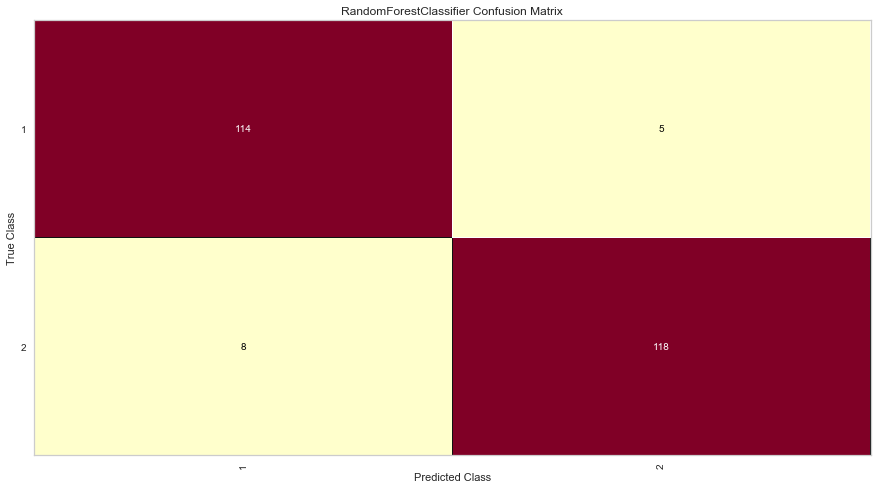

In [ ]:
#checking performance of random forest on oversampled dataset

#training random forest
forest_clf_over = RandomForestClassifier()
forest_clf_over.fit(X_train_over_prep, y_train_over_prep)

# checking performance for oversampled on random forest
forest_pred_over=forest_clf_over.predict(X_test_over_prep)

# # checking class balance in prediction to ensure that both classes are represented
print(np.unique(forest_pred_over ))

 
# checking accuracy
print("Accuracy: ", accuracy_score(y_test_over_prep, forest_pred_over) )

 
# AUCROC score
forest_roc = forest_clf_over.predict_proba(X_test_over_prep)
forest_roc = forest_roc[:,1]
print( "ROC: ",roc_auc_score(y_test_over_prep, forest_roc ))

# classification report
print (classification_report(y_test_over_prep, forest_pred_over))

# confusion matrix for oversampled cassess
fig, ax = plt.subplots()
cm = ConfusionMatrix(forest_clf_over, classes=[1, 2], ax=ax)


# creating the confusion_matrix from scikit learn.
cm.score(X_test_over_prep, y_test_over_prep)

#plotting
cm.poof()

[1. 2.]
Accuracy:  0.8693877551020408
AUCROC score:  0.9210350806989462
              precision    recall  f1-score   support

         1.0       0.87      0.86      0.86       119
         2.0       0.87      0.88      0.87       126

   micro avg       0.87      0.87      0.87       245
   macro avg       0.87      0.87      0.87       245
weighted avg       0.87      0.87      0.87       245



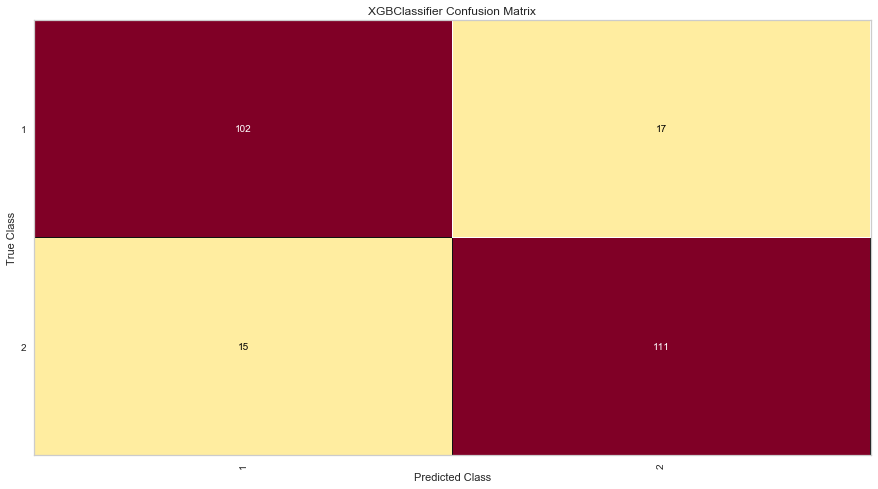

In [ ]:
# checking performance of xgboost on oversampled data
xgb_clf_over = XGBClassifier()
xgb_clf_over.fit(X_train_over_prep, y_train_over_prep)

# Predict on training set
xgb_pred = xgb_clf_over.predict(X_test_over_prep)
 
# checking class balance in prediction to ensure that both classes are represented
print( np.unique( xgb_pred))

 
# checking accuracy
print( "Accuracy: ",accuracy_score(y_test_over_prep, xgb_pred) )

 
# AUCROC score
svm_roc = xgb_clf_over.predict_proba(X_test_over_prep)
svm_roc = svm_roc[:,1]
print("AUCROC score: ", roc_auc_score(y_test_over_prep, svm_roc) )

# classification report
print (classification_report(y_test_over_prep, xgb_pred))

# confusion matrix for penalized-SVM with undersampled
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport
fig, ax = plt.subplots()
cm = ConfusionMatrix(xgb_clf_over, classes=[1, 2], ax=ax)


## creating the confusion_matrix from scikit learn.
cm.score(X_test_over_prep, y_test_over_prep)

#How did we do?
cm.poof()

[1. 2.]
Accuracy:  0.8693877551020408
AUCROC score:  0.8688808856876085
              precision    recall  f1-score   support

         1.0       0.85      0.73      0.79       119
         2.0       0.78      0.88      0.83       126

   micro avg       0.81      0.81      0.81       245
   macro avg       0.81      0.81      0.81       245
weighted avg       0.81      0.81      0.81       245



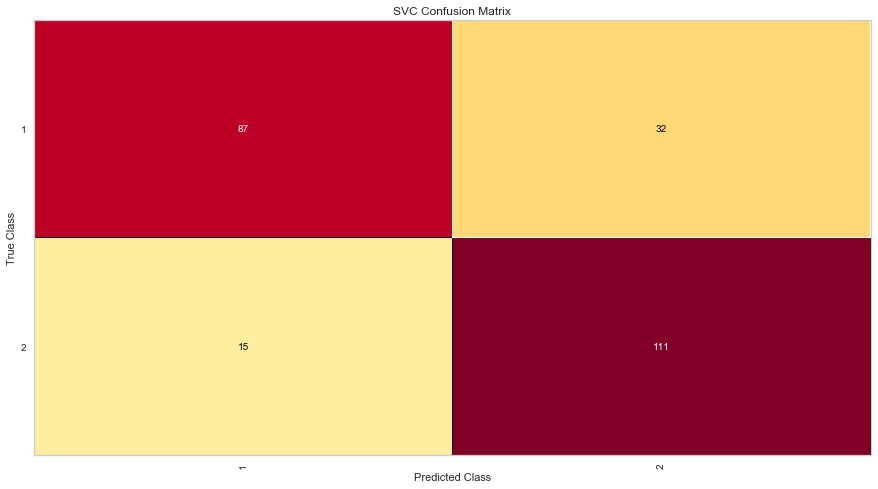

In [ ]:
# checking performance of svm on penalized oversampled data
svm_clf_over = SVC(kernel='linear', 
            class_weight='balanced', # penalize
            probability=True)
 
svm_clf_over.fit(X_train_over_prep, y_train_over_prep)

# Predict on training set
svm_pred = svm_clf_over.predict(X_test_over_prep)
 
#checking class balance in prediction to ensure that both classes are represented
print( np.unique( svm_pred ) )

 
# checking accuracy
print("Accuracy: ", accuracy_score(y_test_over_prep, xgb_pred) )

 
# AUCROC score
svm_roc = svm_clf_over.predict_proba(X_test_over_prep)
svm_roc = svm_roc[:,1]
print("AUCROC score: ", roc_auc_score(y_test_over_prep, svm_roc) )

# classification report
print (classification_report(y_test_over_prep, svm_pred))

# confusion matrix for penalized-SVM with undersampled
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport
fig, ax = plt.subplots()
cm = ConfusionMatrix(svm_clf_over, classes=[1, 2], ax=ax)


# cm.fit(X_train_over_prep, y_train_over_prep)

## creating the confusion matrix from scikit learn.
cm.score(X_test_over_prep, y_test_over_prep)

#plotting
cm.poof()

[1. 2.]
Accuracy: 0.7387755102040816
ROC: 0.8352340936374549
              precision    recall  f1-score   support

         1.0       1.00      0.46      0.63       119
         2.0       0.66      1.00      0.80       126

   micro avg       0.74      0.74      0.74       245
   macro avg       0.83      0.73      0.71       245
weighted avg       0.83      0.74      0.72       245



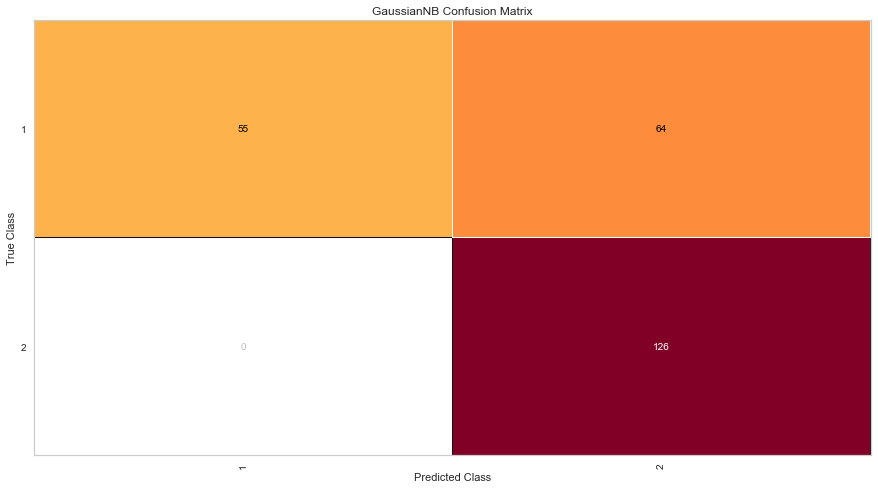

In [ ]:
# checking performance of Naive Bayes on oversampled data
naive_clf_over = GaussianNB()
naive_clf_over.fit(X_train_over_prep, y_train_over_prep)


# Predict on training set
naive_pred = naive_clf_over.predict(X_test_over_prep)
 
#checking class balance in prediction to ensure that both classes are represented
print( np.unique( naive_pred ) )

 
# checking accuracy
print( "Accuracy:",accuracy_score(y_test_over_prep, naive_pred) )

 
# AUCROC score
svm_roc = naive_clf_over.predict_proba(X_test_over_prep)
svm_roc = svm_roc[:,1]
print( "ROC:", roc_auc_score(y_test_over_prep, svm_roc) )

# classification report
print (classification_report(y_test_over_prep, naive_pred))

# confusion matrix for naive bayes with undersampled
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport
fig, ax = plt.subplots()
cm = ConfusionMatrix(naive_clf_over, classes=[1, 2], ax=ax)

#Fit fits the passed model.
cm.fit(X_train_over_prep, y_train_over_prep)

#creating the confusion_matrix from scikit learn.
cm.score(X_test_over_prep, y_test_over_prep)

#plotting
cm.poof()

### Lets check performance with Undersampled classes

In [ ]:
# splitting train and test set
train_set_u, test_set_u = train_test_split(df_under, test_size=0.2, random_state=42)
# defining Xand Y axis
X_train_under=train_set_u.drop("Y", axis=1)
y_train_under=train_set_u["Y"]
X_test_under=test_set_u.drop("Y", axis=1)
y_test_under=test_set_u["Y"]
X_train_under.head()

,Child_Age,Sex,Mother_Age,Distance,Transport_Means,Time,Below_5_years,Marital_Status,Polygamy,Together,Education,Employment,Religion,Group_Membership,Place_of_Birth,Place _of_Sup,Income,Healthcare_Exp
617,1.33,2.00,26.00,2.00,1.00,0.50,2.00,1.00,2.00,2.00,3.00,1.00,1.00,2.00,3.00,1.00,19.85,4.96
649,3.17,1.00,26.00,2.00,1.00,0.42,1.00,1.00,2.00,1.00,3.00,1.00,1.00,1.00,3.00,3.00,4.96,8.93
391,0.75,1.00,23.00,6.00,1.00,2.00,3.00,1.00,1.00,1.00,3.00,1.00,1.00,2.00,3.00,2.00,14.89,3.97
89,0.58,1.00,44.00,3.00,1.00,3.00,nan,nan,2.00,1.00,1.00,1.00,4.00,2.00,3.00,nan,nan,nan
612,4.83,1.00,28.00,3.00,1.00,0.58,3.00,1.00,2.00,1.00,3.00,1.00,1.00,1.00,3.00,nan,14.89,9.93


#### Train set preparation

In [ ]:
#preparing numerical data

# missing values
# filling numerical values with median value
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")
X_train_num_under = X_train_under[["Child_Age","Mother_Age","Time","Below_5_years","Distance","Income","Healthcare_Exp"]]
imputer.fit(X_train_num_under)
X = imputer.transform(X_train_num_under)
X

# Feature scaling
from sklearn.preprocessing import RobustScaler
rob_scaler=RobustScaler()
X_train_scaled=rob_scaler.fit_transform(X)
X_train_scaled

# converting to dataframe
X_train_num_under_prep=pd.DataFrame(X_train_scaled, columns=X_train_num.columns)
X_train_num_under_prep.tail()

,Child_Age,Mother_Age,Time,Below_5_years,Distance,Income,Healthcare_Exp
156,-0.17,0.80,-0.34,-1.00,0.40,2.67,2.75
157,-0.04,-0.50,-0.50,0.00,-0.70,-0.67,0.25
158,0.75,0.90,-0.34,-1.00,-0.40,0.00,0.58
159,0.25,-0.40,-0.50,0.00,-0.60,2.67,-0.08
160,-0.79,0.70,1.00,-1.00,0.00,-0.22,2.42


In [ ]:
# preparing categorical data

# filling categorical values with mode
from sklearn.preprocessing import Imputer
imputer_cat = Imputer(strategy="most_frequent")
X_train_cat= X_train_under.drop(X_train_num_under, axis=1)
imputer_cat.fit(X_train_cat)
filled_cat = imputer_cat.transform(X_train_cat)
filled_cat
# converting to dataframe
X_train_cat_df=pd.DataFrame(filled_cat, columns=X_train_cat.columns)
X_train_cat_df.tail()

# encoding categorical values with pandas get dummies
X_train_cat_under=pd.get_dummies(data=X_train_cat_df, columns=['Transport_Means', 'Education', 'Employment', 'Religion','Place_of_Birth','Place _of_Sup'])
# X_train_cat_under=X_train_cat_under.drop(["Education_6.0"], axis=1)

X_train_cat_under.head()

,Sex,Marital_Status,Polygamy,Together,Group_Membership,Transport_Means_1.0,Transport_Means_2.0,Transport_Means_3.0,Transport_Means_4.0,Education_1.0,Education_2.0,Education_3.0,Education_4.0,Education_5.0,Employment_1.0,Employment_2.0,Employment_3.0,Employment_4.0,Religion_1.0,Religion_2.0,Religion_3.0,Religion_4.0,Place_of_Birth_1.0,Place_of_Birth_2.0,Place_of_Birth_3.0,Place _of_Sup_1.0,Place _of_Sup_2.0,Place _of_Sup_3.0,Place _of_Sup_4.0
0,2.00,1.00,2.00,2.00,2.00,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0
1,1.00,1.00,2.00,1.00,1.00,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0
2,1.00,1.00,1.00,1.00,2.00,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0
3,1.00,1.00,2.00,1.00,2.00,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0
4,1.00,1.00,2.00,1.00,1.00,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0


In [ ]:
#merging num and cat data
X_train_under_prep=pd.concat([X_train_num_under_prep,X_train_cat_under], axis=1)
X_train_under_prep.shape

(161, 36)

In [ ]:
# filling missing values in y train set
imputer = Imputer(strategy="most_frequent")
imputer.fit(y_train_under.values.reshape(-1,1))
y_train_under_prep = imputer.transform(y_train_under.values.reshape(-1,1))

### Test set preparation

In [ ]:
#preparing numerical data

# missing values
# filling numerical values with median value
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")
X_test_num_under = X_test_under[["Child_Age","Mother_Age","Time","Below_5_years","Distance","Income","Healthcare_Exp"]]
imputer.fit(X_test_num_under)
X = imputer.transform(X_test_num_under)
X

# Feature scaling
from sklearn.preprocessing import RobustScaler
rob_scaler=RobustScaler()
X_test_scaled=rob_scaler.fit_transform(X)
X_test_scaled

# converting to dataframe
X_test_num_under_prep=pd.DataFrame(X_test_scaled, columns=X_test_num_under.columns)
X_test_num_under_prep.tail()

,Child_Age,Mother_Age,Time,Below_5_years,Distance,Income,Healthcare_Exp
36,0.08,-0.57,2.98,0.00,8.17,-0.36,3.25
37,-0.70,-1.14,1.19,-1.00,2.83,-0.40,0.38
38,-0.15,0.86,0.00,1.00,0.00,2.36,0.75
39,0.19,-0.14,0.00,0.00,0.50,-0.45,0.25
40,-0.15,0.29,-0.60,-1.00,0.17,-0.18,-0.12


In [ ]:
# preparing categorical data

# filling categorical values with mode
from sklearn.preprocessing import Imputer
imputer_cat = Imputer(strategy="most_frequent")
X_test_cat= X_test_under.drop(X_test_num_under, axis=1)
imputer_cat.fit(X_test_cat)
filled_cat = imputer_cat.transform(X_test_cat)
filled_cat
# converting to dataframe
X_test_cat_df=pd.DataFrame(filled_cat, columns=X_test_cat.columns)
X_test_cat_df.tail()

# encoding categorical values with pandas get dummies
X_test_cat_under=pd.get_dummies(data=X_test_cat_df, columns=['Transport_Means', 'Education', 'Employment', 'Religion','Place_of_Birth','Place _of_Sup'])
X_test_cat_under.head()

,Sex,Marital_Status,Polygamy,Together,Group_Membership,Transport_Means_1.0,Transport_Means_2.0,Transport_Means_3.0,Transport_Means_4.0,Education_1.0,Education_2.0,Education_3.0,Education_4.0,Education_5.0,Employment_1.0,Employment_2.0,Employment_3.0,Employment_4.0,Religion_1.0,Religion_2.0,Religion_3.0,Religion_4.0,Place_of_Birth_1.0,Place_of_Birth_2.0,Place_of_Birth_3.0,Place_of_Birth_4.0,Place _of_Sup_1.0,Place _of_Sup_2.0,Place _of_Sup_3.0
0,2.00,1.00,1.00,2.00,2.00,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0
1,1.00,1.00,1.00,2.00,1.00,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0
2,2.00,2.00,2.00,1.00,2.00,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0
3,1.00,1.00,2.00,1.00,2.00,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0
4,2.00,1.00,2.00,1.00,1.00,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0


In [ ]:
#merging num and cat data
X_test_under_prep=pd.concat([X_test_num_under_prep,X_test_cat_under], axis=1)
X_test_under_prep.shape

(41, 36)

In [ ]:
# filling missing values in y test set
imputer = Imputer(strategy="most_frequent")
imputer.fit(y_test_under.values.reshape(-1,1))
y_test_under_prep = imputer.transform(y_test_under.values.reshape(-1,1))

### Training and model evaluation

[1. 2.]
Accuracy : 0.4634146341463415
AUROC score : 0.4641148325358852
              precision    recall  f1-score   support

         1.0       0.50      0.86      0.63        22
         2.0       0.00      0.00      0.00        19

   micro avg       0.46      0.46      0.46        41
   macro avg       0.25      0.43      0.32        41
weighted avg       0.27      0.46      0.34        41



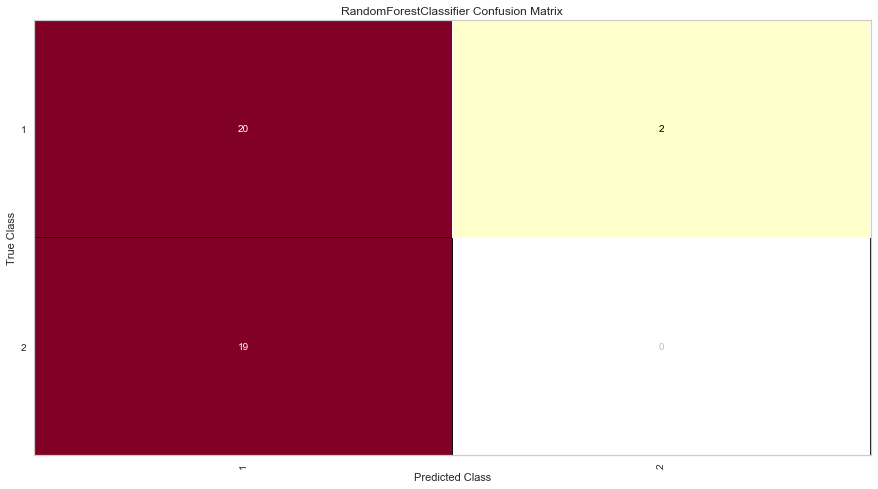

In [ ]:
#checking performance of random forest on oversampled dataset
#training random forest
from sklearn.ensemble import RandomForestClassifier
forest_clf_under = RandomForestClassifier()
forest_clf_under.fit(X_train_under_prep, y_train_under_prep)

# checking performance on random forest
forest_pred_under=forest_clf_under.predict(X_test_under_prep)

#checking class balance in prediction to ensure that both classes are represented
print( np.unique( forest_pred_under ))

 
# checking accuracy
print("Accuracy :", accuracy_score(y_test_under_prep, forest_pred_under) )

 
# AUCROC score
forest_roc = forest_clf_under.predict_proba(X_test_under_prep)
forest_roc = forest_roc[:,1]
print( "AUROC score :", roc_auc_score(y_test_under_prep, forest_roc ))

# classification report
print (classification_report(y_test_under_prep, forest_pred_under))

# confusion matrix for oversampled cassess
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport
fig, ax = plt.subplots()
cm = ConfusionMatrix(forest_clf_under, classes=[1, 2], ax=ax)

#Fit fits the passed model. 
cm.fit(X_train_under_prep, y_train_under_prep)

## creating the confusion_matrix from scikit learn.
cm.score(X_test_under_prep, y_test_under_prep)

#plotting
cm.poof()

Undersampled classes performed poorly so we decided to go with oversampled classes

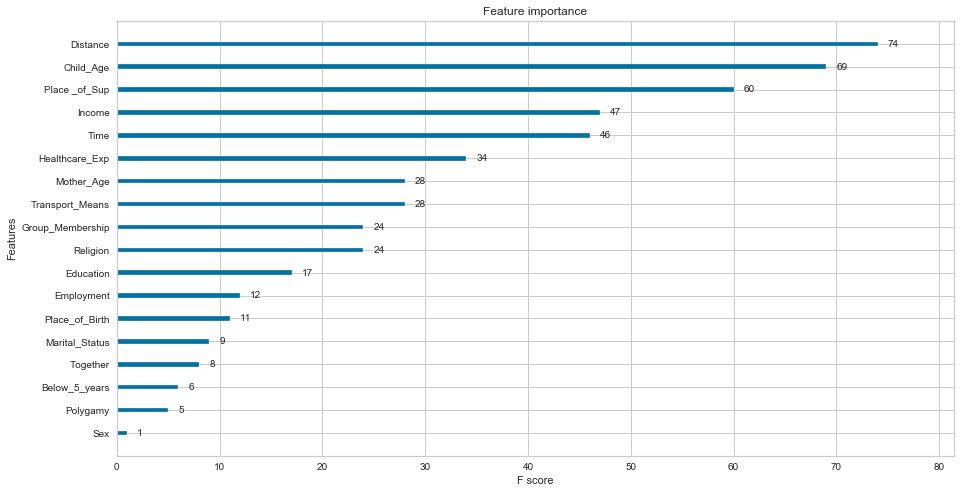

In [ ]:
# examining feature importance with the  best model
import xgboost as xgb
xgb_clf_over = XGBClassifier()
xgb_clf_over.fit(X_train_over_orig, y_train_over_prep)
# xgb.plot_tree(xgb_clf_over, num_trees=10)
xgb.plot_importance(xgb_clf_over)
plt.show()

Text(0.5, 0, 'Relative Importance')

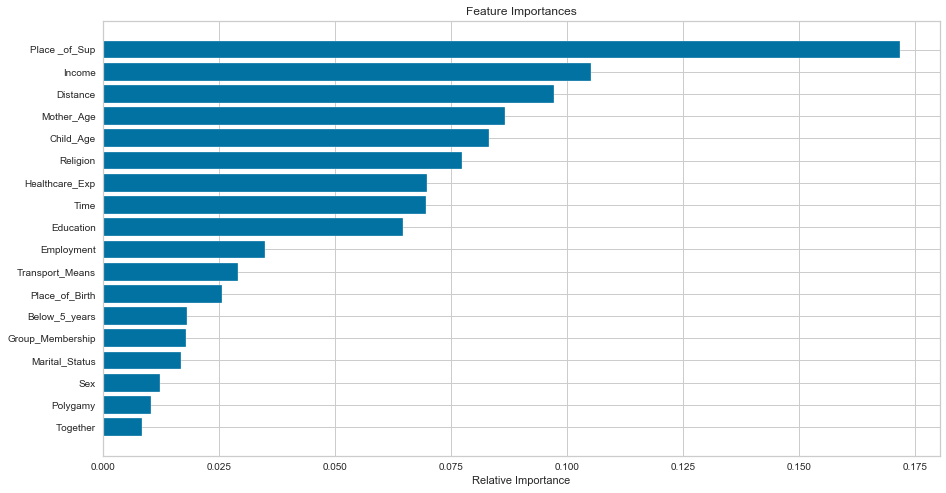

In [ ]:
forest_over = RandomForestClassifier()
forest_over.fit(X_train_over_orig, y_train_over_prep)

importances = forest_over.feature_importances_
indices = np.argsort(importances)
features=X_train_over_orig.columns
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [ ]:
!conda install graphviz

In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
tree.export_graphviz(forest_clf_over.estimators_[0], out_file='tree_from_forest.dot')
(graph,) = pydot.graph_from_dot_file('tree_from_forest.dot')
graph.write_png('tree_from_forest.png')